In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import glob
import sys
from scipy import interpolate ,optimize
from scipy.interpolate import UnivariateSpline
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')

#import functions from file in path 
sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/functions')
from functions2 import MS_finder2

data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/' # #

file_ext= '.dat2'

In [2]:
# sort file names so that they are listed by mass, then rotation velocity 
m_val=lambda x : int(x.split('/')[-1].split('.')[0].split('-')[0][1:])
v_val= lambda x : int(x.split('/')[-1].split('.')[0].split('-')[1])

s1=sorted(glob.glob(data_dir +'*'+ file_ext), key=v_val)
data_files=sorted(s1, key= m_val)


#cut stars heavier than 40M, at they do not contribute to Be
data_files=filter(lambda x: m_val(x) < 60, data_files)
#print data_files

mass_list=[]
for f in data_files:
    mass_list=np.append(mass_list, int(m_val(f)))
    
mass_list=np.unique(mass_list)


print 'masses of models :\n',mass_list

masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25. 30. 35. 40. 50.]


In [3]:
data_df=pd.DataFrame()
i=0
for fil in data_files:
    message="working on file " +str(i) + " / "+ str(len(data_files)) #+ " :time loop "+str(i2) + " / "+ str(n_vals)
    sys.stdout.write ('\r'+ message)
    i=i+1
    df_ms, T_ms= MS_finder2(fil)
    

        # index of time closest to t 
        #T_indx=(df_ms['1:t[s]']-t).abs().argmin()
        #t_i=df_ms['1:t[s]'].loc[T_indx]
        #V= df_ms['9:v_surf[km/s]'].loc[T_indx] 
        #if star is rotating 
    if v_val(fil) != 0:
        V_over_Vcrit=df_ms['9:v_surf[km/s]']/ df_ms['8:v_crit[km/s]']
        #print V_over_Vcrit
        V_initial=df_ms['9:v_surf[km/s]'][0:100].mean()
        V_crit_initial=df_ms['8:v_crit[km/s]'][0:100].mean()
        crit_frac= V_initial/V_crit_initial
        V_crit=df_ms['8:v_crit[km/s]']
    else:
        V_over_Vcrit=0
        V_initial=0
        V=0
        crit_frac=0
        V_crit=0
    ti_over_tms=df_ms['1:t[s]']/T_ms

    #df_ms=df_ms.append(pd.DataFrame([[f_name,m,V_initial,V, T_ms,V_over_Vcrit, ti_over_tms]],
                                                      #columns=['f-name','M','V_initial', 'V', 'T_MS', 'V/Vcrit', 't_i/T_MS']))
    df_ms['V_crit']=V_crit
    df_ms['V/Vcrit']=V_over_Vcrit
    df_ms['t/Tms']=ti_over_tms
    df_ms['V_init']=V_initial
    df_ms['M']= m_val(fil)
    df_ms['V']=v_val(fil)
    df_ms['T_MS']= T_ms
    df_ms['V/Vc_initial']= crit_frac
    
    data_df=data_df.append(df_ms)

working on file 171 / 172

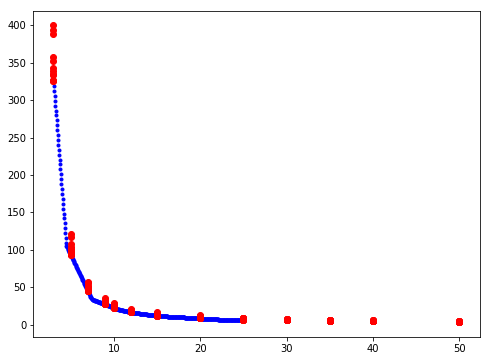

In [4]:
df=data_df[data_df['1:t[s]']== 0]


#print df
x=np.array(df['V_init'])#[-20:]
y=np.array(df['M'])#[-20:]
z=np.array(df['T_MS'])#[-20:]

        #print x,y,z
f = interpolate.interp2d(x, y, z, kind='linear')

m_list=np.linspace(3,25,500)
for i in m_list:
    #plt.plot(i, (f(420,i)), 'k.' )
    plt.plot(i, (f(0,i))/1e6, 'b.' )
    
plt.plot(y,z/1e6, 'ro')
plt.show()

In [5]:
t=0
m_i=15
Be_value=0.7

    
plot_df=pd.DataFrame()
for Be_value in (0.6,0.7,0.8,0.9,0.99):
    plot_arr=np.array([])
    for m_i in [30,35,40,50]:#mass_list:
        sys.stdout.write ('\r'+ str(Be_value)+'--'+str(m_i))
        dm=data_df[data_df.M ==m_i]
        v_crit_min_arr=np.array([[]])

        for t_frac in np.linspace(0,0.99, 100):
            dg=pd.DataFrame()
            for vi in np.unique(dm['V_init'])[1:]:
                di= dm[(dm['V_init']==vi)  ]
                ti=((di['t/Tms']-(t_frac)).abs()).argmin()
                dn= di.iloc[ti]
                dg=dg.append(dn)
                
            
            #straight_line1=interpolate.interp1d( dg['V/Vcrit'],dg['V_init'],
            #                                       bounds_error=False, assume_sorted=True)
            straight_line1=interpolate.interp1d(dg['V_init'], dg['V/Vcrit'],
                                                   bounds_error=False, assume_sorted=True)
            
            v_cands=np.array([])
            for v in np.linspace(200,600, 5e4):
                if  np.abs(straight_line1(v)-Be_value)/Be_value < 1e-3:
                    #print v
                    v_critmin=v
                    break
                else:
                    v_critmin=np.nan
            for v in np.linspace(600,v_critmin, 5e4):
                if  np.abs(straight_line1(v)-Be_value)/Be_value < 1e-3:
                    #print v
                    v_crit_max=v
                    break
                else: v_crit_max=np.nan
            #v_critmin=straight_line1(Be_value)
            #v_crit_max=np.nan
            plot_df=plot_df.append(pd.DataFrame([[m_i,t_frac,v_critmin,v_crit_max, Be_value ]], 
                                           columns=['M', 't/T', 'V_critmin','V_critmax', 'Be_value']))
            
            #plt.plot( dg['V_init'],dg['V/Vcrit'], 'ro')
            #plt.title(str(m_i)+'   '+str(np.round(t_frac,3)))
            #plt.plot(  np.linspace(0,600,100),straight_line1(np.linspace(0,600,100)))
            #plt.show()
            #print v_cands


        #a=[[m_i,np.nanmin(v_crit_min_arr[1::2])]]

        #print a 
        
        #plot_arr=np.append(plot_arr, a)
    

    #x=plot_arr[0::2]
    #y=plot_arr[1::2]

    #plt.plot(x,y, 'o-', label=Be_value)
    #plt.legend()
    
#plt.xlabel(r'$M_{\odot}$')
#plt.ylabel(r'$V_{init}/kms^{-1}$')
#plt.title('Max. $V_{init}$ for $V/V_{crit}$ to reach certain value')
#plt.savefig('V_crit-min_plot2.png', dpi=300)
#plt.show()

#print plot_df.to_string()
print 'DONE'
#plot_df.to_pickle('./plot_df.pk')

M= 15 T_ms-max [13.57371282]
M= 15 T_ms-min [11.60980603]
0.99--50DONE


In [3]:

plot_df=pd.read_pickle('./plot_df.pk')




print np.unique(plot_df.M)

[ 3.  5.  7.  9. 10. 12. 15. 20. 25. 30. 35. 40. 50.]


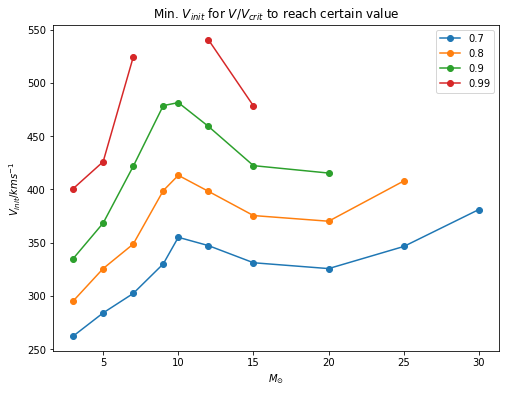

In [12]:
grouped = plot_df.groupby(['Be_value','M'])

plot2=pd.DataFrame()

for g,group in grouped: 
    y_vals=[]
    #print group
    x=group['M']
    y=group['V_critmin'].min(skipna=True)
    y_vals=y_vals.append(y)
    plot2=plot2.append(pd.DataFrame([[g[1], y, g[0]]], columns=['M', 'V_critmin', 'Be_value']))
    
#print plot_df
#print plot2
grouped = plot2.groupby(['Be_value'])
for g,group in grouped: 
    if g==0.6:
        continue 
    x=group.M
    y=group['V_critmin']
    
    plt.plot(x,y,'o-', label=g)
    
    
plt.xlabel(r'$M_{\odot}$')
plt.ylabel(r'$V_{init}/kms^{-1}$')
plt.title('Min. $V_{init}$ for $V/V_{crit}$ to reach certain value')

plt.legend()
#plt.savefig('V_crit-min_plot4.png', dpi=300)
plt.show()



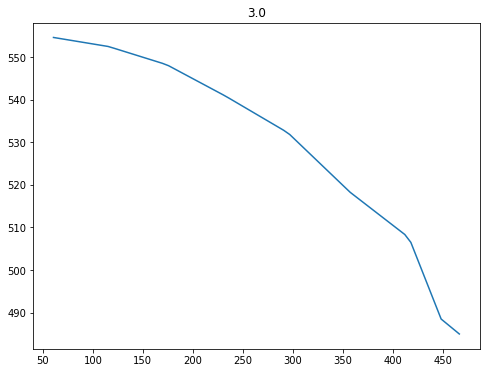

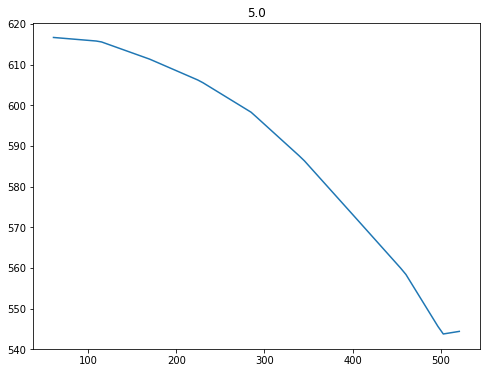

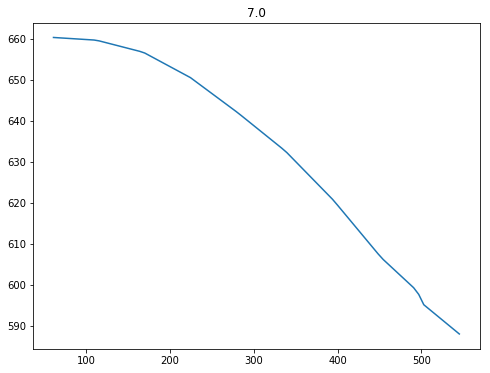

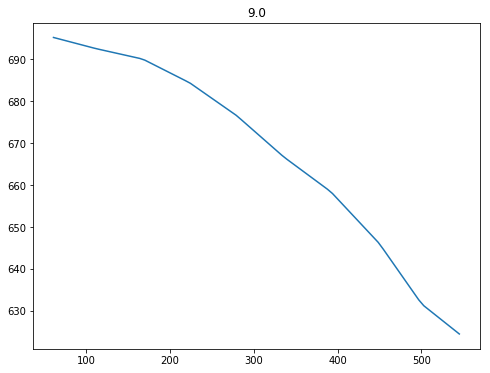

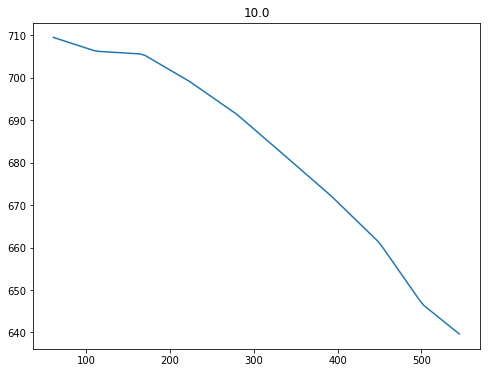

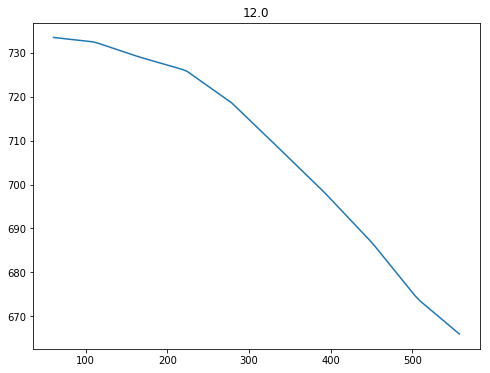

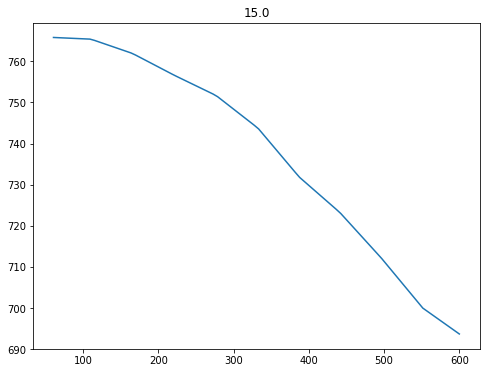

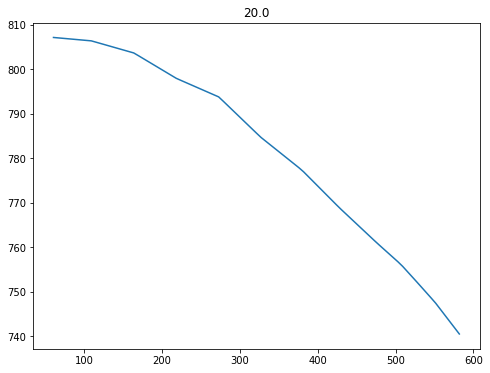

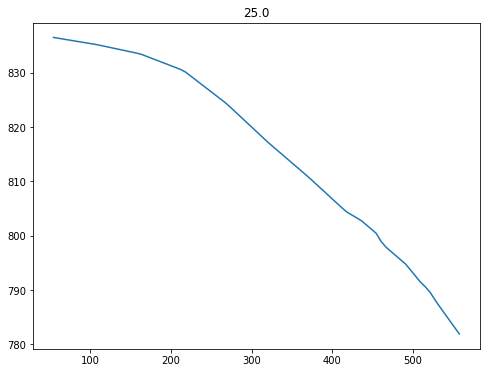

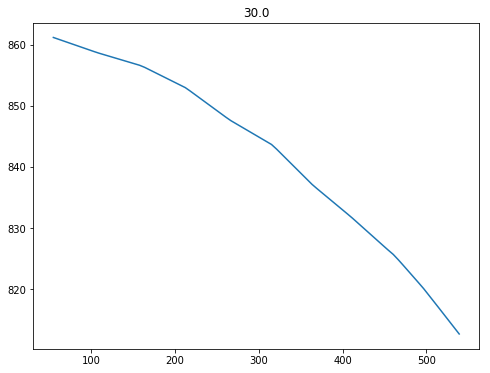

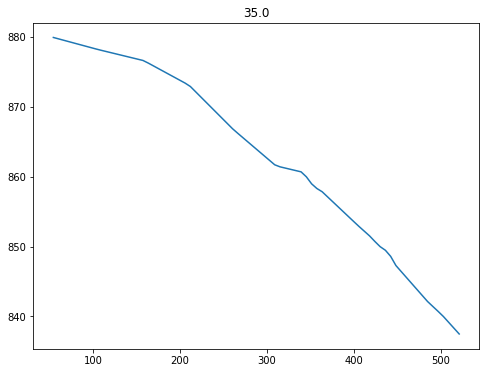

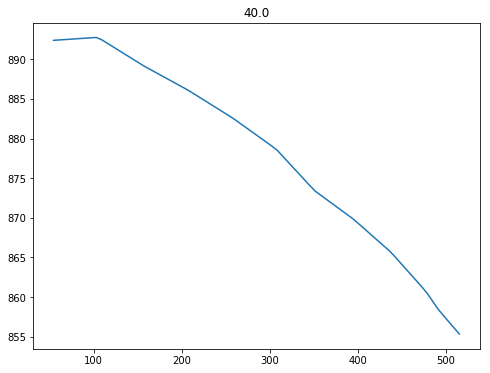

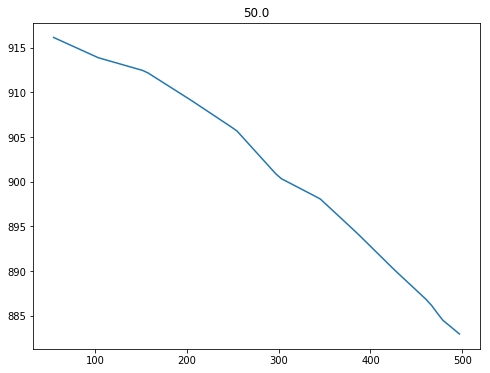

{3.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b72e4628>, 5.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b72e40a8>, 7.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b61faba8>, 40.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b61fa100>, 9.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b60f1838>, 10.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b63887e0>, 12.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b6d2ee10>, 15.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b6d2e158>, 50.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b61fa890>, 35.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b6e2c4c8>, 20.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b6d2e628>, 25.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b6d2e940>, 30.0: <scipy.interpolate.interpolate.interp1d object at 0x7fc0b6d57368>}


In [13]:
interp_df=pd.DataFrame()
v_crit_interpolation={}
for m in  mass_list:
    dx=data_df[data_df.M ==m]
    for vi in np.unique(dx['V_init'])[1:]:
        dl=dx[(dx['V_init']==vi)]
        x=dl['V_crit'][0:10].mean()
        y=dl['V_init']
        #print m, vi,x
        #plt.plot(vi,x, 'o')
        interp_df=interp_df.append(pd.DataFrame([[m,vi,x]], columns=['M', 'V_init', 'V_crit_init']))
        
    #plt.title(m)    
    #plt.ylim(0,1.05)
    #plt.axhline(0.9)
    #plt.xlabel('V initial')
    #plt.ylabel('V_crit initial')
    #plt.show()
interp_df.head()

grouped = interp_df.groupby(['M'])
for g,group in grouped: 
    x=group['V_init']
    y=group['V_crit_init']
    straight_line1=interpolate.interp1d(x,y,
                                        bounds_error=False, assume_sorted=True)
    
    vs=np.linspace(0,600,100)
    v_crit_interpolation[g]= straight_line1
    plt.plot(vs, straight_line1(vs))
    plt.title(g)
    plt.show()
    
    
print v_crit_interpolation

In [14]:

interp_vcrit= lambda x: v_crit_interpolation[x['M']](x['V_critmin'])
plot_df.reset_index(inplace=True)
for index, row in plot_df.iterrows():
    #print index
    #print v_crit_interpolation[row.M](row['V_critmin'])
    #row['Vcrit_init']= v_crit_interpolation[row.M](row['V_critmin'])
    plot_df.set_value(index,'Vcrit_init', v_crit_interpolation[row.M](row['V_critmin']))
    
print plot_df.to_string()

      index     M   t/T   V_critmin   V_critmax  Be_value  Vcrit_init
0         0   3.0  0.00  313.522270  314.066589      0.60  528.102530
1         0   3.0  0.01  313.226265  313.771146      0.60  528.168935
2         0   3.0  0.02  312.386248  312.932725      0.60  528.357384
3         0   3.0  0.03  311.922238  312.463835      0.60  528.461479
4         0   3.0  0.04  311.034221  311.571708      0.60  528.660696
5         0   3.0  0.05  310.322206  310.866812      0.60  528.820429
6         0   3.0  0.06  309.802196  310.336171      0.60  528.937088
7         0   3.0  0.07  309.034181  309.563749      0.60  529.109384
8         0   3.0  0.08  308.386168  308.922748      0.60  529.254758
9         0   3.0  0.09  307.650153  308.182240      0.60  529.419875
10        0   3.0  0.10  307.202144  307.735047      0.60  529.520381
11        0   3.0  0.11  306.498130  307.020574      0.60  529.678319
12        0   3.0  0.12  305.786116  306.315711      0.60  529.838051
13        0   3.0  0

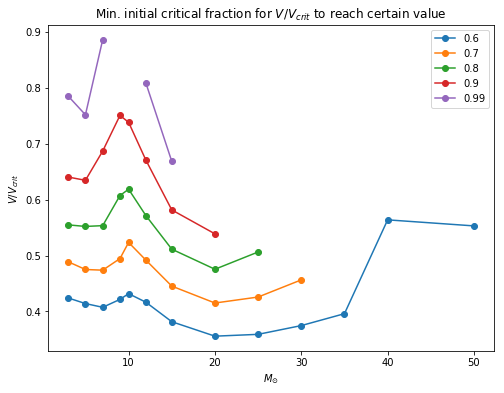

In [15]:
grouped = plot_df.groupby(['Be_value','M'])

plot2=pd.DataFrame()

for g,group in grouped: 
    x=group['M']
    idx=group['V_critmin'].argmin(skipna=True)
    if np.isfinite(idx):
        Vi=group['V_critmin'].loc[idx]
        Vc=group['Vcrit_init'].loc[idx]
        y=Vi/Vc
    else:
        y=np.nan
        
    plot2=plot2.append(pd.DataFrame([[g[1], y, g[0]]], columns=['M', 'V/V_critmin', 'Be_value']))

#print plot_df
#print plot2.to_string()
grouped = plot2.groupby(['Be_value'])
for g,group in grouped: 
    x=group.M
    y=group['V/V_critmin']
    
    plt.plot(x,y,'o-', label=g)
    
    
plt.xlabel(r'$M_{\odot}$')
plt.ylabel(r'$V/V_{crit}$')
plt.title('Min. initial critical fraction for $V/V_{crit}$ to reach certain value')

plt.legend()
#plt.savefig('V_crit-min_plot3.png', dpi=300)
plt.show()


In [ ]:
for vi in np.unique(data_df['V'])[1:]:
    for m in  mass_list:
        dx=data_df[data_df.M ==m]
    
        dl=dx[(dx['V']==vi)]
        y=dl['V_crit'][0:10].mean()
        x=m
        #print m, vi,x
        plt.plot(x,y, 'o')
        
    plt.title(vi)    
    #plt.ylim(0,1.05)
    #plt.axhline(0.9)
    #plt.xlabel('V initial')
    #plt.ylabel('V_crit initial')
    plt.show()

In [ ]:
print data_df.head()

In [ ]:
#print MS_finder2('/home/ben/Documents/Bonn-uni/internship/takeaway_data/f10-50.mw.dat2')
print data_df.columns.tolist()
plt.clf()
for m in np.unique(data_df.M):
    
    dx=data_df[data_df.M ==m]
    for vi in np.unique(dx['V_init'])[1::4]:
        dl=dx[(dx['V_init']==vi) & (dx['t/Tms'] <0.99)]
        x=dl['t/Tms']
        y=dl['2:M/Msun'] *dl['5:R/Rsun']**2 #  /dl['2:M/Msun'].iloc[0]
        plt.plot(x,y, label=str(int(vi)) +' km/s')
        plt.title(m)    
        
    #plt.ylim(0,1.05)
    plt.xlabel(r'$t/T_{MS}$')
    plt.ylabel(r'$I$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=5)
    
    plt.savefig('/home/ben/Documents/Bonn-uni/internship/plots/I/'+str(m)+'.png', dpi=300,bbox_inches='tight')
    plt.show()
    plt.clf()